In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import keras
from random import sample, shuffle
from math import floor
from matplotlib import pyplot as plt
from sklearn.preprocessing import scale

In [19]:
class Dense(tf.Module):  # Denesly connected leyer
    # Note: No need for `in_features`
    def _linear_act(x):
        return x

    def __init__(self, out_features, act_func=_linear_act, name=None):
        super().__init__(name=name)
        self.is_built = False
        self.out_features = out_features  # Number of outputs
        self.act_func = act_func  # Activation function

    def __call__(self, x):
        # Create variables on first call.
        if not self.is_built:
            self.w = tf.Variable(tf.random.normal(
                [x.shape[-1], self.out_features]),
                name='w')
            self.b = tf.Variable(tf.zeros([self.out_features]), name='b')
            self.is_built = True

        y = tf.matmul(x, self.w) + self.b
        return self.act_func(y)


class Model(tf.Module):
    def __init__(self, layers=[], name=None):
        super().__init__(name=name)
        self.layers = layers

    # Feed forward on call
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


def _loss(model, inputs, target_y):
    pred_y = model(inputs)
    return tf.reduce_mean(tf.square(target_y - pred_y))


def _grad(model, inputs, targets):
    with tf.GradientTape() as tape:
        loss_value = _loss(model, inputs, targets)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)


def _get_batches(X, Y, batch_size):
    n_data = len(X)
    # Shuffle data
    c = list(zip(X, Y))
    shuffle(c)
    X, Y = zip(*c)
    # Splitting into batches
    X, Y = np.array(X).astype('float32'), np.array(Y).astype('float32')
    x, y = [], []
    for i in range(0, n_data - batch_size, batch_size):
        x.append(X[i:i + batch_size])
        y.append(Y[i:i + batch_size])
    return x, y


def train(model,
          X,
          Y,
          epochs=10,
          batch_size=1,
          optimiser=tf.optimizers.Adam(0.01)):

    train_loss_results = []
    valid_loss_results = []
    test_loss_results = []

    for epoch in range(epochs):
        ##STATS##
        epoch_loss_avg = tf.keras.metrics.Mean()
        epoch_loss_valid = tf.keras.metrics.Mean()
        epoch_loss_test = tf.keras.metrics.Mean()
        ##STATS##
        # Creating new batches for every epoch
        x, y = _get_batches(X, Y, batch_size)
        for i in range(0, len(x)):  # For all each batch
            loss_value, grads = _grad(model, x[i], y[i])
            ##STATS##
            epoch_loss_avg.update_state(loss_value)
            epoch_loss_valid.update_state(_loss(model, x_valid, y_valid))
            epoch_loss_test.update_state(_loss(model, x_test, y_test))
            ##STATS##
            optimiser.apply_gradients(zip(grads, model.trainable_variables))

        train_loss_results.append(epoch_loss_avg.result().numpy())
        valid_loss_results.append(epoch_loss_valid.result().numpy())
        test_loss_results.append(epoch_loss_test.result().numpy())
        if ((epoch + 1) % 50 == 0):
            print("Epoch: {}; Loss: {}".format(
                epoch + 1,
                epoch_loss_avg.result().numpy()))
    return (train_loss_results, valid_loss_results, test_loss_results)

In [20]:
P_TRAIN = 0.81  # Fraction of dataset
P_VALID = 0.085

arecibo_df = pd.read_csv('Arecibo_DF')
x_values = arecibo_df.drop(['MHI', 'Name'], axis=1).values.astype('float32')
x_values = scale(x_values)
y_values = arecibo_df['MHI'].values.astype('float32')
y_values = np.reshape(y_values, (-1, 1))

n_data = len(x_values)
n_train = floor(n_data*P_TRAIN)
n_valid = floor(n_data*P_VALID)

c = list(zip(x_values, y_values))
shuffle(c)
x_shuf, y_shuf = zip(*c)

x_train, y_train = x_shuf[0:n_train], y_shuf[0:n_train]
x_valid, y_valid = x_shuf[n_train:n_train +
                            n_valid], y_shuf[n_train:n_train + n_valid]
x_test, y_test = x_shuf[n_train + n_valid:n_data], y_shuf[n_train + n_valid:n_data]

np.save('train_data', [x_train, y_train])
np.save('valid_data', [x_valid, y_valid])
np.save('test_data', [x_test, y_test])
#train_df = pd.DataFrame(np.array([x_train, y_train]))
#valid_df = pd.DataFrame(np.array([x_valid, y_valid]))
#test_df = pd.DataFrame(np.array([x_test, y_test]))


#train_df.to_csv('train_DF.txt', index = False)
#valid_df.to_csv('valid_DF.txt', index = False)
#test_df.to_csv('test_DF.txt', index = False)


print("Training set size: " + str(len(x_train)))
print("Test set size: " + str(len(x_test)))
print("Validtaion set size: " + str(len(x_valid)))

Training set size: 100
Test set size: 14
Validtaion set size: 10


C:\Users\Gordei\anaconda3\envs\tf_env\lib\site-packages\sklearn\preprocessing\_data.py:194: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\Users\Gordei\anaconda3\envs\tf_env\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Gordei\anaconda3\envs\tf_env\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, co

In [21]:
train_arr = np.load('train_data.npy', allow_pickle=True)
valid_arr = np.load('valid_data.npy', allow_pickle=True)
test_arr = np.load('test_data.npy', allow_pickle=True)
x_train, y_train = train_arr[0].tolist(), train_arr[1].tolist()
x_valid, y_valid = valid_arr[0].tolist(), valid_arr[1].tolist()
x_test, y_test = test_arr[0].tolist(), test_arr[1].tolist()

In [22]:
# adam_model = Model([Dense(8, tf.nn.sigmoid),
#               Dense(16, tf.nn.sigmoid),
#               Dense(16, tf.nn.sigmoid),
#              Dense(1)])
adam_model = Model([Dense(8, tf.nn.sigmoid),
                    Dense(16, tf.nn.sigmoid),
                    Dense(16, tf.nn.sigmoid),
                    Dense(16, tf.nn.sigmoid),
                    Dense(16, tf.nn.sigmoid),
                    Dense(1),])
adam_results = train(adam_model, x_train, y_train, epochs=1000,
                     batch_size=8, optimiser=tf.optimizers.Adam(0.01))

Epoch: 50; Loss: 0.05325210466980934
Epoch: 100; Loss: 0.010770398192107677
Epoch: 150; Loss: 0.008068399503827095
Epoch: 200; Loss: 0.0045026191510260105
Epoch: 250; Loss: 0.00801074132323265
Epoch: 300; Loss: 0.004001330584287643
Epoch: 350; Loss: 0.0028411317616701126
Epoch: 400; Loss: 0.004100483376532793
Epoch: 450; Loss: 0.0012069775257259607
Epoch: 500; Loss: 0.0020025151316076517
Epoch: 550; Loss: 0.001514873350970447
Epoch: 600; Loss: 0.0014590779319405556
Epoch: 650; Loss: 0.0013278572587296367
Epoch: 700; Loss: 0.0014757001772522926
Epoch: 750; Loss: 0.0022620484232902527
Epoch: 800; Loss: 0.0023047546856105328
Epoch: 850; Loss: 0.0005944283911958337
Epoch: 900; Loss: 0.0005629510269500315
Epoch: 950; Loss: 0.0015978912124410272
Epoch: 1000; Loss: 0.0010998857906088233


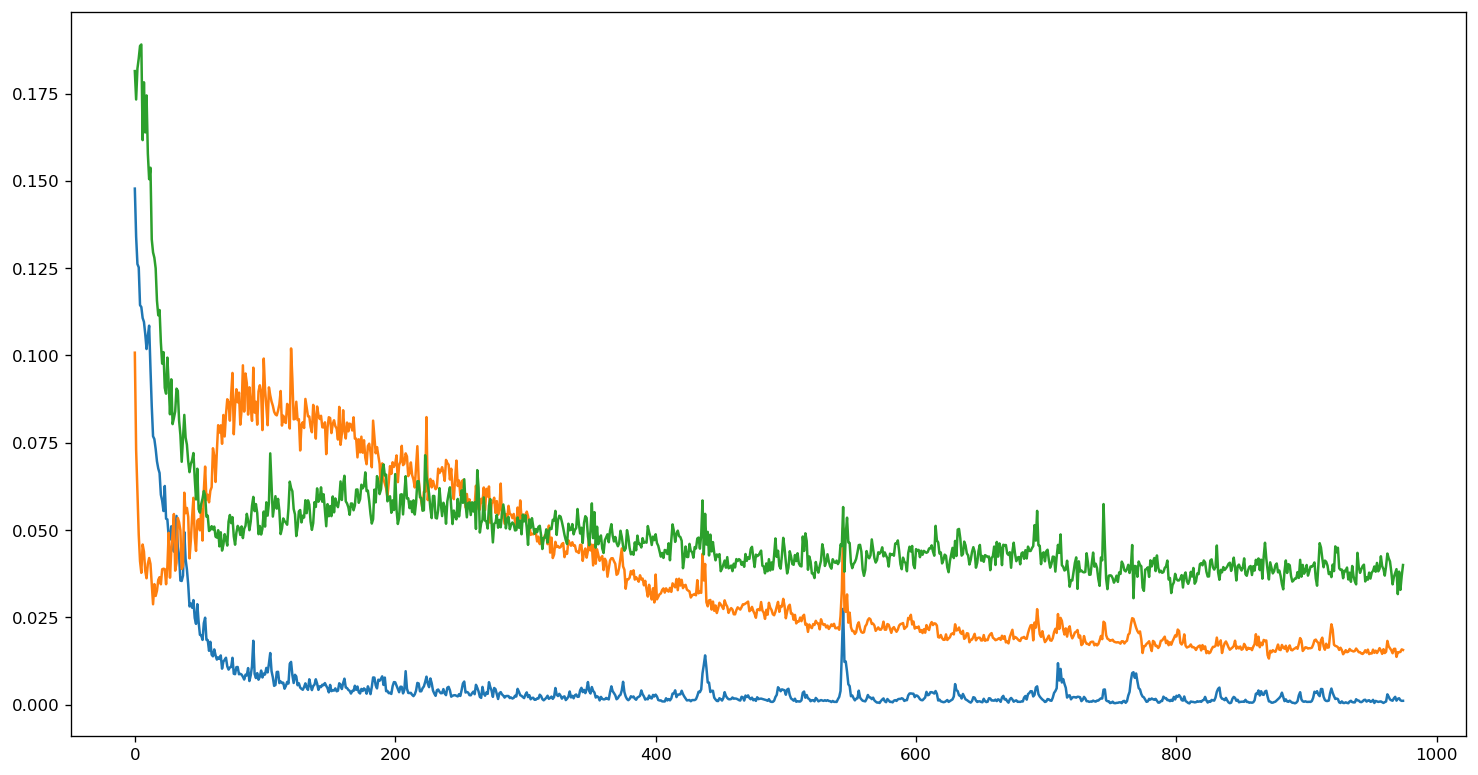

In [23]:
plt.figure(dpi=120, figsize=(15, 8))
plt.plot(adam_results[0][25:])
plt.plot(adam_results[1][25:])
plt.plot(adam_results[2][25:])

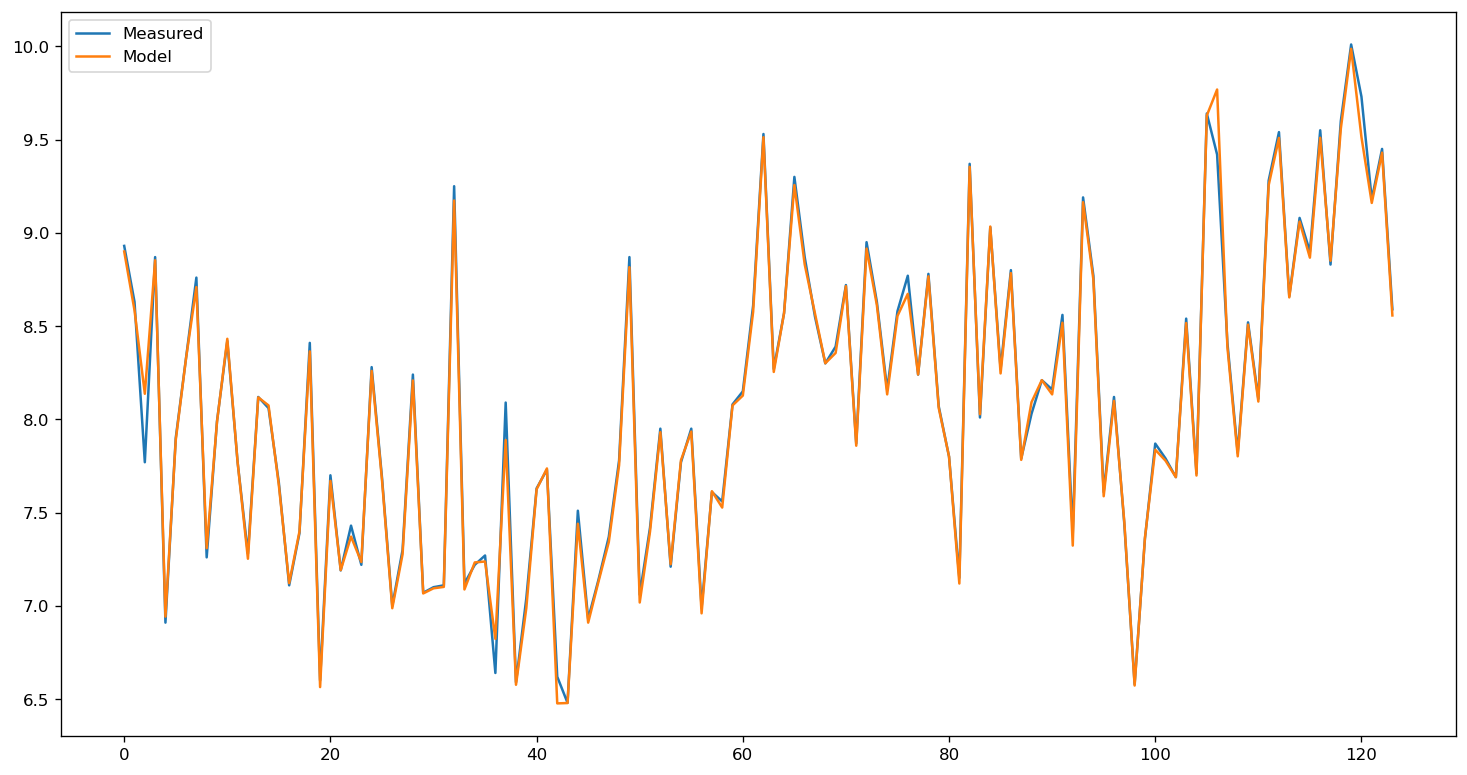

In [8]:
y_pred = adam_model(x_values)
y = y_values
plt.figure(dpi=120, figsize=(15, 8))
measured_l, = plt.plot(range(0, len(y)), y)
model_l, = plt.plot(range(0, len(y)), y_pred)
plt.legend([measured_l, model_l], ('Measured', 'Model'))
plt.show()

In [9]:
nancay_df = pd.read_csv('Nancay_DF')
nancay_df = nancay_df[~nancay_df['Name'].isin(arecibo_df['Name'])]

In [10]:
nancay_x = nancay_df.drop(['Name', 'MHI'], axis=1).values.astype('float32')
nancay_x = scale(nancay_x)

nancay_y = nancay_df['MHI'].values 
nancay_y = nancay_y

C:\Users\Gordei\anaconda3\envs\tf_env\lib\site-packages\sklearn\preprocessing\_data.py:194: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\Users\Gordei\anaconda3\envs\tf_env\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


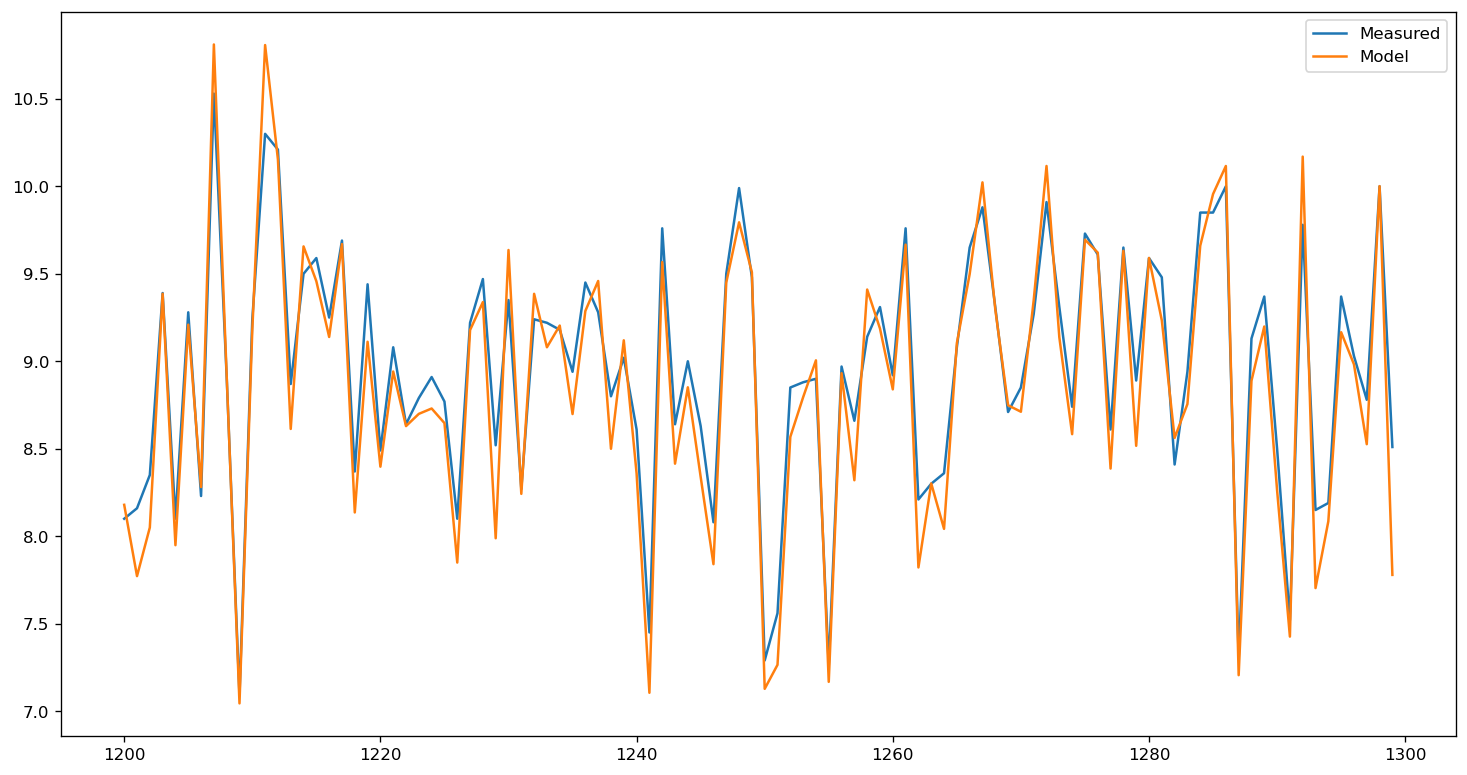

In [11]:
strt = 1200
ran = 100
nancay_x_sub = nancay_x[strt:ran+strt]
nancay_y_sub = nancay_y[strt:ran + strt]
nancay_pred_y = adam_model(nancay_x_sub)

plt.figure(dpi=120, figsize=(15, 8))
measured_l, = plt.plot(range(strt, ran + strt), nancay_y_sub)
model_l, = plt.plot(range(strt, ran + strt), nancay_pred_y + (np.mean(nancay_y) - arecibo_df['MHI'].mean()))
plt.legend([measured_l, model_l], ('Measured', 'Model'))
plt.show()

In [12]:
nancay_pred = adam_model(nancay_x)
print("Nancay prediction mean: " + str(np.mean(nancay_pred)))
print("Nancay observation mean: " + str(np.mean(nancay_y)))

print("Arecibo prediction mean: " + str(np.mean(adam_model(x_values))))
print("Arecibo observation mean: " + str(arecibo_df['MHI'].mean()))

Nancay prediction mean: 7.9859157
Nancay observation mean: 8.925523223279239
Arecibo prediction mean: 8.061443
Arecibo observation mean: 8.074596774193548


In [13]:
print(arecibo_df.mean(axis = 0))
arecibo_means = arecibo_df.mean(axis =0)
#arecibo_means = scale(arecibo_means)
ar_mhi_mean = arecibo_means[10]
def calculate_distance(mean, value):
    return np.sum(value-mean)

Vopt    2808.370968
g-z        0.607258
gMAG     -15.931290
M*         8.039701
sSFR      -9.783953
rms        0.561290
VHI     2810.572581
W50       96.379032
FHI        1.041371
S/N       28.317823
MHI        8.074597
dtype: float64


In [14]:
nancay_values = nancay_df.drop('Name', axis = 1).values
#nancay_values = scale(nancay_values)
sample_size = 100
max_distance = 2
acc_dev= 0.2



best_value_index = 0 
last_dist = 0
sample = []
to_ignore = []
for i in range(sample_size-1):
    smallest_suit_sep = 999
    for j in range(len(nancay_values)):
        if j in to_ignore:
            continue
        value = nancay_values[j]
        distance = calculate_distance(ar_mhi_mean, value[10])
        if(abs(distance) > max_distance):
            continue
        sep_from_needed_value = distance + last_dist
        if(abs(sep_from_needed_value) < acc_dev and
           sep_from_needed_value < smallest_suit_sep):       
            smallest_suit_sep = sep_from_needed_value
            best_value_index = j
            break
    sample.append(nancay_df.values[best_value_index])
    last_dist = calculate_distance(ar_mhi_mean, nancay_values[best_value_index][10])
    to_ignore.append(best_value_index)
sample = np.array(sample)
sample_df = pd.DataFrame(sample, columns = nancay_df.columns)

In [15]:
#print(sample_df)

In [16]:
sample_x = sample_df.drop(['Name', 'MHI'], axis=1).values.astype('float32')
sample_x = scale(sample_x)

sample_y = sample_df['MHI'].values 
print(np.mean(sample_y))

print("Arecibo observation mean: " + str(arecibo_df['MHI'].mean()))

8.116363636363639
Arecibo observation mean: 8.074596774193548


C:\Users\Gordei\anaconda3\envs\tf_env\lib\site-packages\sklearn\preprocessing\_data.py:194: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\Users\Gordei\anaconda3\envs\tf_env\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


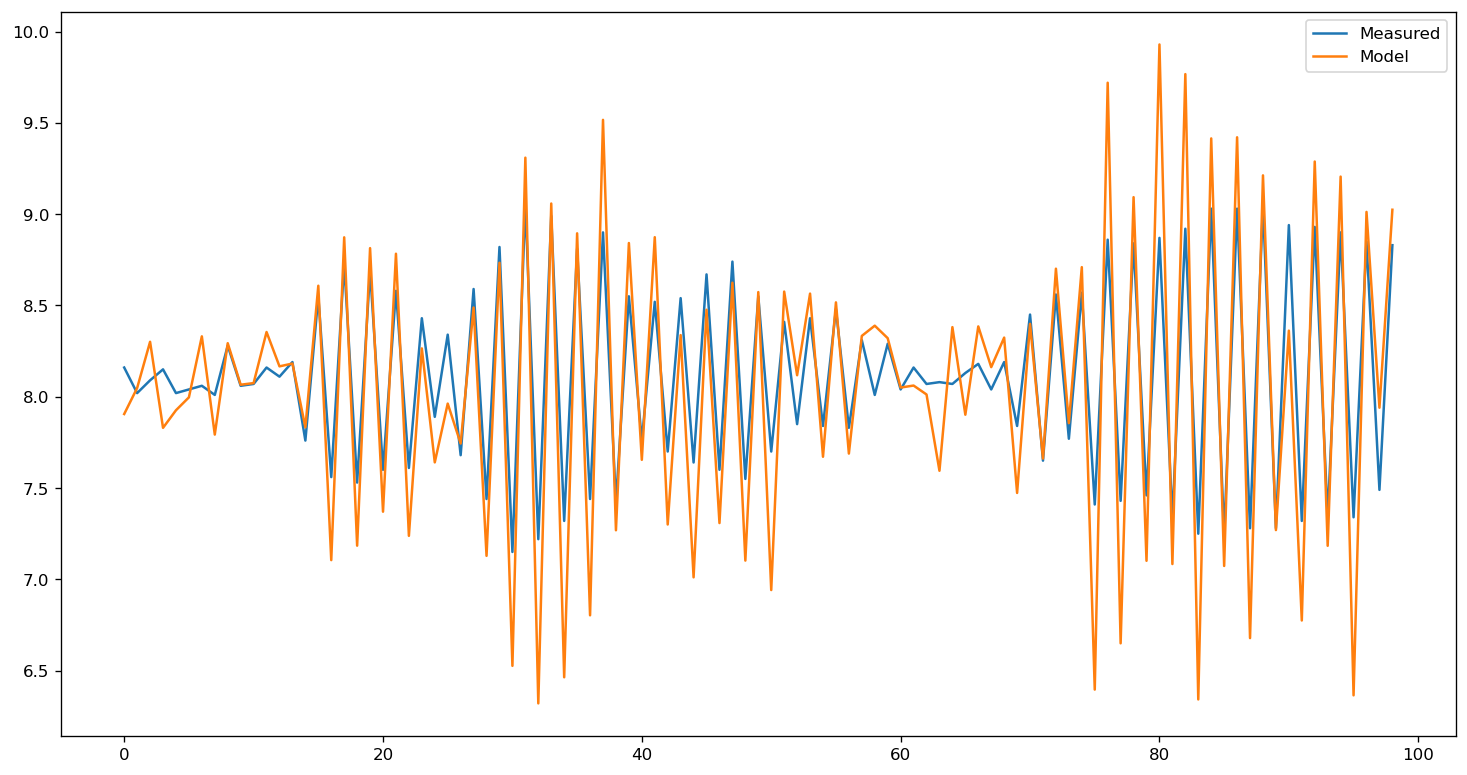

In [17]:
sample_pred_y = adam_model(sample_x)
plt.figure(dpi=120, figsize=(15, 8))
measured_l, = plt.plot(range(0, len(sample_pred_y)), sample_y)
model_l, = plt.plot(range(0, len(sample_pred_y)), sample_pred_y)
plt.legend([measured_l, model_l], ('Measured', 'Model'))
plt.show()

In [18]:
sample_df_withpred = sample_df
sample_df_withpred['PRED MHI'] = pd.Series(np.squeeze(sample_pred_y))
sample_df_withpred.to_csv('Nancay_subset.txt', index = False)